# App to find Cheap Flights

# Introduction:

In 2014, the cheapest fare from New York to Vienna was found to be around $800, but according to the advertised fares, where for a select no. of dates, these tickets were between $350 and $450. 

It all seemed to be a good deal and one might wonder if whether it is true or not. The industry does mistake the occasional mistakes on fares, because airlines occasionally and accidentally do happen to post fares that exclude fuel surcharges. Normally, it is expected that the advanced algorithms employed by these airlines would be updating fares that takes into account large number of factors, however due to the order generations of systems in place, mistakes do happen.



# 1 Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from time import sleep

# 2 - Retrieving the Data from scraping the web:

Fare data are obtained from a AJAX-based (Asynchornous JavaScript) webpage, this will require a browser to do the work. For such a task, there will be a need for two of the following pacakges: Selenium and ChromeDriver.

- Selenium is a package for automating web browsers.
- ChromeDriver is a headless browser, meaning there isn't a user interface.

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver

chromeDriver_file = 'chromedriver'
chromeDriver_file_conda = 'chromedriver-binary alias'

import os
path = os.path.abspath(chromeDriver_file)
print('pathway to ChromeDriver is: ' + '\n' + path)

# Set the ChromeDriver pathway:
chromeDriver_path = path

browser = webdriver.Chrome(chromeDriver_path)

pathway to ChromeDriver is: 
/Users/y.s.lee/OneDrive/Packt - Python Machine Learning Blue Prints/Project 2 - App to find Cheap Flights/chromedriver


### 2.1 Set the URL (from google flights):

Dates are set to 1st of June to 15th of June in the year 2020 (note: that these dates can be changed to anything).

NOTE: Need to use the Freebase IDs for city/region of interest for travel. for example, m/06y57 is for Sydney. m/0f04v is for empty search. m/02_286 is for NYC.

It is possible to find it when searching in google from th ebelow link:
https://www.google.com.mx/travel/guide?q=New+York+City&sa=X&rlz=1C1CHBD_esMX769MX769&output=search&tra=%5B%22AMAbHIJDZRALeKKuHEbLXHGOJ3aS9zzCTg:1579328461567%22,%22syndey%22,%22/m/02_286%22%5D&tcfs=EhUKCS9tLzAyXzI4NhIITmV3IFlvcms&dest_mid=/m/06y57#dest_mid=/m/06y57&tcfs=EiwKCC9tLzA2eTU3EgZTeWRuZXkaGAoKMjAyMC0wMi0wMxIKMjAyMC0wMi0wNw

And to confirm it with the link below: make sure to control+f and search for Freebase ID.
https://www.wikidata.org/wiki/Q3130

In [3]:
# Input webpage as string:
flight_web_sats = 'https://www.google.com/travel/explore?tfs=CBsQAxojagcIARIDU1lEEgoyMDIwLTA2LTAxcgwIBBIIL20vMDJqOXoaI2oMCAQSCC9tLzAyajl6EgoyMDIwLTA2LTE1cgcIARIDU1lEcAFAAUgB&curr=AUD&gl=au&hl=en&authuser=0&origin=https%3A%2F%2Fwww.google.com&dest_mid'

# Retrieve the webpage's content using Selenium:
browser.get(flight_web_sats)

# Check the title of the webpage:
browser.title

'Explore'

In [4]:
# Check to see if the required information from the webpage was captured: Take a Screenshot and save as 'test_flights.png'.
current_work_directory = os.getcwd()
browser.save_screenshot(current_work_directory + '/test_flights.png')

True

### 2.2 Parsing the DOM to extract the individual flight data from the HTML tags:

Document Object Model (DOM) is the collection of the individual elements on a webpage. These will include things like HTML tags, like 'body' and 'div', or classes and IDs.

In [5]:
# Parsing:
soup = BeautifulSoup(browser.page_source, "html.parser")

#### Extract the individual city data:

In [6]:
# Get the city data:
# At the time of HTML scraping, the flight data was inside <div class='MeBuN'>
# Or the by XPATH: //*[@id="flt-app"]/c-wiz/c-wiz/nav/div[1]/nav/div/div[2]/ol/li[1]/div

sleep(7)

flight_cards = soup.select('div[class*=MebuN]')

# Check out a single flight card:
flight_cards[0]


<div class="MebuN"><div class="L32YH" style="background-image: url('//t1.gstatic.com/images?q=tbn:ANd9GcSWD3RIhb5WVm8o0tVuh7Ygbe67MxTKwnYGRJ1cbhLQupYphfzlG37c6WbGvIIwlP7oGh1QoYZq'), url('//www.gstatic.com/flights/app/runway_200.png')"></div><div class="tsAU4e"><div class="wIuJz"><h3 class="W6bZuc YMlIz">London</h3><div class="ZjDced CQYfx"><img alt="China Airlines" class="C5fbBf" data-iml="7574.610000003304" height="16" src="//www.gstatic.com/flights/airline_logos/70px/CI.png" width="16"/><span class="nx0jzf">1 stop</span><span class="qeoz6e U325Rc"></span><span class="Xq1DAb">1 day 3 hr 20 min</span></div></div><div class="Q70fcd sSHqwe"><div class="MJg7fb"><span class="QB2Jof xLPuCe" data-gs="CidHbzBoVUJHLS0tLS0tLS0tcGZkczIyQUFBQUFGNGxCeDRNMkNnQUESATAaCwj0xQYQAhoDQVVE">$1,073</span></div></div></div></div>

From the piece of HTML information above, it can be noticed that the information needed is within the markup. 
For example: 
- the destination is seen here 'class="W6bZuc YMlIz" London',
- where the duration of the flight is 'class="Xq1DAb" 1 day 3 hr 20 min' 
- and prices are located at 'class="QB2Jof xLPuCe" datags="CidHQ2lQekJHLS0tLS0tLS0tcGZiMTI5QUFBQUFGNGlrY29Bby1aQUESATAaCwj+wAQQAhoDVVNE">$739'.

#### Next, is to obtain the required data from the markup:


In [8]:
# For-loop to extract the relevant information:
# At the time of HTML scraping, the price information are stored in <div class='MJg7fb'>

# for card in flight_cards:
#     print(card.select('h3')[0].text)
#     print(card.select('div[class*=MJg7fb]')[0].text)
#     print('\n')

# Perform clean up of 'Great value' tags before the prices:
for card in flight_cards:
    print(card.select('h3')[0].text)
    print(card.select('div[class*=MJg7fb]')[0].text.replace('Great value',""))
    print('\n')

browser.quit()

print('Testing Complete.')

London
$1,073


Paris
$1,167


Rome
$938


Amsterdam
$907


Athens
$1,332


Dublin
$1,272


Manchester
$1,243


Frankfurt
$1,000


İstanbul
$1,260


Stockholm
$1,465


Barcelona
$1,142


Milan
$1,247


Berlin
$936


Madrid
$1,244


Zürich
$1,255


Munich
$1,396


Copenhagen
$1,157


Reykjavík
$1,788


Vienna
$1,351


Edinburgh
$1,310


Moscow
$1,277


Malta
$1,398


Helsinki
$1,603


Venice
$1,491


Budapest
$1,400


Geneva
$1,391


Lisbon
$1,352


Belgrade
$1,408


Brussels
$1,300


Prague
$1,388


Skopje
$1,406


Oslo
$1,486


Warsaw
$1,462


Glasgow
$1,297


Birmingham
$1,470


Nice
$1,402


Zagreb
$1,465


Düsseldorf
$1,451


Hamburg
$1,474


Newcastle upon Tyne
$1,303


Testing Complete.


From the above, it can be confirmed that it is possible to retrieve the relevant data from the HTML. 

#### Next, is to retrieve flights that presents with the lowest cost and non-stop fares from the starting destination to the arrival destination. These flights would be for a 26 week period. All this is done by making a full scrape and parsing of a large number of fares.

#### Import the required libraries:

In [9]:
import datetime
from datetime import date, timedelta
from time import sleep

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

In [11]:
#======= Restart ChromeDriver =========
path = os.path.abspath(chromeDriver_file)
print('pathway to ChromeDriver is: ' + '\n' + path)

# Set the ChromeDriver pathway:
chromeDriver_path = path

browser = webdriver.Chrome(chromeDriver_path)

#======= Scraping the Web Data =========

week_period = 26
start_date = '2020-06-01'
end_date = '2020-06-15'

departure_destination = "Sydney"
arrival_destination = "Europe"

# Format the flight dates: with the python datetime standard.
startFlight_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
endFlight_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

# Dictionary for Fares:
flightFare_dict = {}

for idx in range(week_period):
    sat_start = str(startFlight_date).split()[0]
    sat_end = str(endFlight_date).split()[0]
    flightFare_dict.update({sat_start: {}})
    
    # Load webpage:
    sats = "https://www.google.com/flights?hl=en#flt=.." + sat_start + "*.." + sat_end + ";c:AUD;e:1;sd:1;t:h"
    sleep(np.random.randint(3,7))
    browser.get(sats)
    print('Index: ' + str(idx) + ' Starting Browser and searching link: Google ' + browser.title + '. Dates are: ' + sat_start + ' and ' + sat_end + '.' )
    
    # Input information to search for flights:
    wait_10sec = WebDriverWait(browser, 10) # Seconds of Waiting.

    print('Link Loaded, Entering Travel Details now.')

    # Departure Search: input of departure location.
    departureDestination_link = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[2]/div[1]')))
    departureDestination_link.click()
    departureDestination_link = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="sb_ifc50"]/input')))
    sleep(1)
    departureDestination_link.send_keys(departure_destination)
    sleep(2)
    departureDestination_link.send_keys(Keys.ENTER)

    # Arrival Search: input of arrival location.
    arrivalDestination = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[2]/div[2]')))
    arrivalDestination.click()
    arrivalDestination = wait_10sec.until(EC.presence_of_element_located((By.XPATH, '//*[@id="sb_ifc50"]/input')))
    sleep(1)
    arrivalDestination.send_keys(arrival_destination)
    sleep(2)
    arrivalDestination.send_keys(Keys.ENTER)

    # Get new URL:
    sleep(1)
    new_browser_url = browser.current_url
    print('After inputting the destinations and searching, the new URL is: \n' + new_browser_url)

    # Finally, click on the 'Search' button:
    floatingActionButton_click = browser.find_elements_by_xpath('//*[@id="flt-app"]/div[2]/main[1]/div[4]/div/div[3]/div/div[4]/floating-action-button')[0]
    sleep(2)
    floatingActionButton_click.click()
    print('Search done. Next is to get a list of the travel information.')
    
    
    # Extract Relevant Data from webpage:
    
    print('Collecting data.')
    sleep(30)
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    flight_cards = soup.select('div[class*=MebuN]')
    
    for card in flight_cards:
        while True:
            try:
                city = card.select('h3')[0].text
                fare = card.select('div[class*=MJg7fb]')[0].text.replace('Great value',"")    
                print(city)
                print(fare)
                print('\n')
                flightFare_dict[sat_start] = {**flightFare_dict[sat_start], **{city: fare}}
                
            except RuntimeError as detail:
                print('Handling run-time error: ' + detail)
                continue
            break
        
#     sleep(7)
    startFlight_date = startFlight_date + timedelta(days = 7)
    endFlight_date = endFlight_date + timedelta(days = 7)
    print('\n')
    
browser.quit()
print('Quiting Broswer, Data Collection Complete.')

pathway to ChromeDriver is: 
/Users/y.s.lee/OneDrive/Packt - Python Machine Learning Blue Prints/Project 2 - App to find Cheap Flights/chromedriver
Index: 0 Starting Browser and searching link: Google Flights. Dates are: 2020-06-01 and 2020-06-15.
Link Loaded, Entering Travel Details now.
After inputting the destinations and searching, the new URL is: 
https://www.google.com/flights?hl=en#flt=..2020-06-01*..2020-06-15;c:AUD;e:1;sd:1;t:h
Search done. Next is to get a list of the travel information.
London
A$1,073


Paris
A$1,167


Rome
A$938


Amsterdam
A$907


Athens
A$1,332


Dublin
A$1,272


Manchester
A$1,243


Frankfurt
A$1,000


İstanbul
A$1,260


Stockholm
A$1,465


Barcelona
A$1,142


Milan
A$1,247


Berlin
A$936


Madrid
A$1,244


Zürich
A$1,255


Munich
A$1,396


Copenhagen
A$1,157


Reykjavík
A$1,788


Vienna
A$1,351


Edinburgh
A$1,310


Moscow
A$1,277


Malta
A$1,398


Helsinki
A$1,603


Venice
A$1,491


Budapest
A$1,400


Geneva
A$1,391


Lisbon
A$1,352


Belgrade
A$1,408


In [13]:
flightFare_dict

{'2020-06-01': {'London': 'A$1,073',
  'Paris': 'A$1,167',
  'Rome': 'A$938',
  'Amsterdam': 'A$907',
  'Athens': 'A$1,332',
  'Dublin': 'A$1,272',
  'Manchester': 'A$1,243',
  'Frankfurt': 'A$1,000',
  'İstanbul': 'A$1,260',
  'Stockholm': 'A$1,465',
  'Barcelona': 'A$1,142',
  'Milan': 'A$1,247',
  'Berlin': 'A$936',
  'Madrid': 'A$1,244',
  'Zürich': 'A$1,255',
  'Munich': 'A$1,396',
  'Copenhagen': 'A$1,157',
  'Reykjavík': 'A$1,788',
  'Vienna': 'A$1,351',
  'Edinburgh': 'A$1,310',
  'Moscow': 'A$1,277',
  'Malta': 'A$1,398',
  'Helsinki': 'A$1,603',
  'Venice': 'A$1,491',
  'Budapest': 'A$1,400',
  'Geneva': 'A$1,391',
  'Lisbon': 'A$1,352',
  'Belgrade': 'A$1,408',
  'Brussels': 'A$1,300',
  'Prague': 'A$1,388',
  'Skopje': 'A$1,406',
  'Oslo': 'A$1,486',
  'Warsaw': 'A$1,462',
  'Glasgow': 'A$1,297',
  'Birmingham': 'A$1,470',
  'Nice': 'A$1,402',
  'Zagreb': 'A$1,465',
  'Düsseldorf': 'A$1,451',
  'Hamburg': 'A$1,474',
  'Newcastle upon Tyne': 'A$1,303'},
 '2020-06-08': {'Lond

## 2.3 Check out the data collected from the 26 week period:

Begin with checking out flights heading to Berlin.

In [15]:
# Checking out outward flights to Berlin:

city_key = 'Berlin'
for key in flightFare_dict:
    print(key, flightFare_dict[key][city_key])

2020-06-01 A$936
2020-06-08 A$1,001
2020-06-15 A$1,001
2020-06-22 A$1,086
2020-06-29 A$1,131
2020-07-06 A$1,273
2020-07-13 A$1,086
2020-07-20 A$1,041
2020-07-27 A$1,041
2020-08-03 A$1,086
2020-08-10 A$1,046
2020-08-17 A$936
2020-08-24 A$936
2020-08-31 A$891
2020-09-07 A$1,046
2020-09-14 A$1,254
2020-09-21 A$966
2020-09-28 A$966
2020-10-05 A$896
2020-10-12 A$1,321
2020-10-19 A$1,276
2020-10-26 A$1,231
2020-11-02 A$1,231
2020-11-09 A$1,231
2020-11-16 A$1,231
2020-11-23 A$1,321


It can be seen that there will be some need of further cleaning of the data, such as removing the 'A$'for AUD dollars from the price data and to remove the ',' commas.

In [16]:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})

In [17]:
city_dict

{'2020-06-01': 936,
 '2020-06-08': 1001,
 '2020-06-15': 1001,
 '2020-06-22': 1086,
 '2020-06-29': 1131,
 '2020-07-06': 1273,
 '2020-07-13': 1086,
 '2020-07-20': 1041,
 '2020-07-27': 1041,
 '2020-08-03': 1086,
 '2020-08-10': 1046,
 '2020-08-17': 936,
 '2020-08-24': 936,
 '2020-08-31': 891,
 '2020-09-07': 1046,
 '2020-09-14': 1254,
 '2020-09-21': 966,
 '2020-09-28': 966,
 '2020-10-05': 896,
 '2020-10-12': 1321,
 '2020-10-19': 1276,
 '2020-10-26': 1231,
 '2020-11-02': 1231,
 '2020-11-09': 1231,
 '2020-11-16': 1231,
 '2020-11-23': 1321}

After some cleaning, it can be seen that the values appears as wanted. 

#### Plot the data:

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

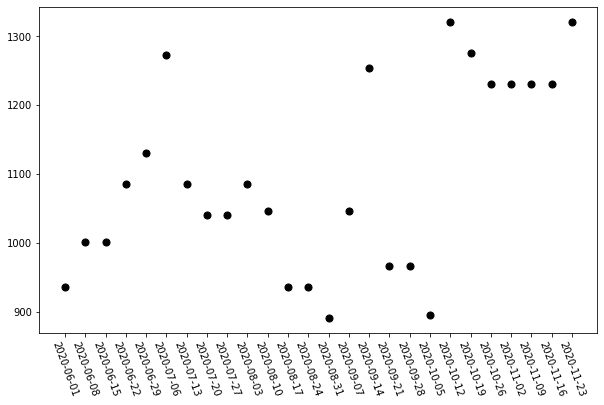

In [19]:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

From the plot above, where they are flights from Sydney to Berlin, shows 26 consecutive weeks of data and have some variations to these fares. These can range from 900 AUD dollars to 1350 AUD dollars. It can also be said that initially from just eyeballing it, there isn't a certain pattern to these fares.

#### Now, having a look at another City: Milan.

In [20]:
# Checking out outward flights to Milan:

city_key = 'Milan'
for key in flightFare_dict:
    print(key, flightFare_dict[key][city_key])

2020-06-01 A$1,247
2020-06-08 A$1,247
2020-06-15 A$1,247
2020-06-22 A$1,883
2020-06-29 A$2,232
2020-07-06 A$2,016
2020-07-13 A$1,669
2020-07-20 A$1,605
2020-07-27 A$1,425
2020-08-03 A$1,247
2020-08-10 A$1,376
2020-08-17 A$1,425
2020-08-24 A$1,425
2020-08-31 A$1,425
2020-09-07 A$1,469
2020-09-14 A$1,221
2020-09-21 A$1,528
2020-09-28 A$1,361
2020-10-05 A$1,235
2020-10-12 A$1,221
2020-10-19 A$1,195
2020-10-26 A$1,132
2020-11-02 A$1,132
2020-11-09 A$1,127
2020-11-16 A$1,127
2020-11-23 A$1,195


In [21]:
city_dict = {}

for k, v in flightFare_dict.items():
    city_dict.update({k: int(v[city_key].replace(',','').split('$')[1])})

[Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-08'),
 Text(0, 0, '2020-06-15'),
 Text(0, 0, '2020-06-22'),
 Text(0, 0, '2020-06-29'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-13'),
 Text(0, 0, '2020-07-20'),
 Text(0, 0, '2020-07-27'),
 Text(0, 0, '2020-08-03'),
 Text(0, 0, '2020-08-10'),
 Text(0, 0, '2020-08-17'),
 Text(0, 0, '2020-08-24'),
 Text(0, 0, '2020-08-31'),
 Text(0, 0, '2020-09-07'),
 Text(0, 0, '2020-09-14'),
 Text(0, 0, '2020-09-21'),
 Text(0, 0, '2020-09-28'),
 Text(0, 0, '2020-10-05'),
 Text(0, 0, '2020-10-12'),
 Text(0, 0, '2020-10-19'),
 Text(0, 0, '2020-10-26'),
 Text(0, 0, '2020-11-02'),
 Text(0, 0, '2020-11-09'),
 Text(0, 0, '2020-11-16'),
 Text(0, 0, '2020-11-23')]

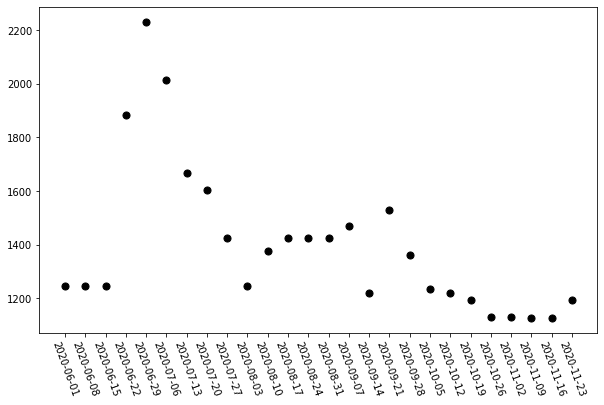

In [22]:
# Convert prices to integers:
prices = [int(x) for x in city_dict.values()]

# Extract the Date data from the dictionary:
dates = city_dict.keys()

# Plot:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x = dates,
            y = prices,
            color = 'black',
            s = 50           
           )
ax.set_xticklabels(dates, rotation = -70)

From the plot above, where they are flights from Sydney to Milan and the fares ranges from 1150 AUD dollars to 2250 AUD dollars. The types of cheap fares of interests can be seen from the dates of 26th Oct to 16th of Nov (around 1150 AUD dollars). These are the Outliers of interest.

#### Next is to create an outlier detection system to notify the user of such cheap fares

# 3 Outlier Detection System: for cheap flights:

Outliers can be describe as an observation that lies outside the overall pattern of a distribution. (ref: http://mathworld.wolfram.com/Outlier.html)
Such outliers can be determined by techniques that are both parametric and non-parametric. Once of the techniques utilised is the density-based spatial clustering of application with noise (DBSCAN). Another is called Grubb's Test. Depending on the type of data that present itself, where it can be multivariate or univariate, the technique utilised is different.

For the purpose of this notebook, the data is a univariate time-series data, and that the technique to be used is called the Generalised Extreme Studentised Deviate (GESD) test specifically for outliers. 

